<a href="https://colab.research.google.com/github/sauravkokane/Bank-Calls-Success-predictions/blob/master/Rainfall_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Write Python Files

### Create Files

In [1]:
%%writefile myimports.py
# file for imports of necessary modules and libraries

Overwriting myimports.py


In [2]:
%%writefile mydisplay.py
# file for display function

Overwriting mydisplay.py


In [3]:
%%writefile mygetdata.py
# File for loading training and testing data

Overwriting mygetdata.py


In [4]:
%%writefile myeda.py
# file for eda classes and functions

Overwriting myeda.py


In [5]:
%%writefile myvisualizations.py
# file for visualization classes and functions

Overwriting myvisualizations.py


In [6]:
%%writefile mypreprocess.py
# file for preprocessing on data

Overwriting mypreprocess.py


In [7]:
%%writefile mymodels.py
# file for custom ml model class

Overwriting mymodels.py


In [8]:
%%writefile myscore.py
# file for evaluation of models

Overwriting myscore.py


### Append In Files

#### Requirements.txt

In [9]:
%%writefile myreqs.txt
pandas==2.2.3
numpy==2.2.4
matplotlib==3.10.1
seaborn==0.13.2
scikit-learn==1.6.1
xgboost==3.0.0

Overwriting myreqs.txt


#### Imports

In [10]:
%%writefile -a myimports.py
# General Libraries
import os
import gc
import joblib
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from cudf import DataFrame as cuDF
except ImportError:
    cuDF = None

Appending to myimports.py


In [11]:
%%writefile -a myimports.py
# Preprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (
    StratifiedKFold,
    KFold,
    GroupKFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    PowerTransformer,
    FunctionTransformer,
)
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

from sklearn.feature_selection import SelectKBest, f_classif


Appending to myimports.py


In [12]:
%%writefile -a myimports.py
# ml algorithms
# linear
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

# distance based
from sklearn.neighbors import KNeighborsClassifier

# tree
from sklearn.tree import DecisionTreeClassifier

# ensamble learning
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

# pipelines
from sklearn.pipeline import Pipeline, make_pipeline

Appending to myimports.py


In [13]:
%%writefile -a myimports.py
# metrices
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

Appending to myimports.py


#### Display

In [14]:
%%writefile -a mydisplay.py


from IPython.display import display, HTML, Markdown

CSS = """
.output {
    flex-direction: column;
}
"""

HTML('<style>{}</style>'.format(CSS))

def show(*dfs):
    for df in dfs:
        display(df)

Appending to mydisplay.py


In [15]:
%%writefile -a mydisplay.py

def display_markdown(markdown_text):
    display(Markdown(markdown_text))

Appending to mydisplay.py


#### EDA

In [16]:
%%writefile -a mygetdata.py


def load_data(dataset_path):
    train = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
    test = pd.read_csv(os.path.join(dataset_path, 'test.csv'))
    return train, test

Appending to mygetdata.py


In [17]:
%%writefile -a myeda.py


def get_numeric_or_categorical_columns(df, target_column=None, categorical_threshold=10, ignore_columns=[], get_features:list=None):
    """
    Get lists of all, numeric, categorical, and object features from a DataFrame.
    """
    columns = df.columns.tolist()

    columns = [col for col in columns if col!=target_column and col not in ignore_columns]

    numeric_features = df[columns].select_dtypes(include=np.number).columns.tolist()
    object_features = df[columns].select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_features = [
        col for col in columns
        if (col not in numeric_features) or
        df[col].nunique()<=categorical_threshold
    ]

    get_features = get_features if get_features else ['numeric', 'object', 'categorical']

    ret_features = [columns]

    if get_features:
        if 'numeric' in get_features or 'num' in get_features:
            ret_features.append(numeric_features)

        if 'categorical' in get_features or 'cat' in get_features:
            ret_features.append(categorical_features)

        if 'object' in get_features or 'obj' in get_features:
            ret_features.append(categorical_features)

    return ret_features

Appending to myeda.py


In [18]:
%%writefile -a myeda.py


class AdversarialValidator:
    def __init__(self, model_class, model_params=None, test_size=0.3, random_state=42):
        self.model_class = model_class
        self.model_params = model_params or {}
        self.test_size = test_size
        self.random_state = random_state
        self.model = None
        self.auc_score = None
        self.feature_importances_ = None

    def fit(self, train_data, test_data):
        train_data = train_data.copy()
        test_data = test_data.copy()
        train_data["is_test"] = 0
        test_data["is_test"] = 1

        data = pd.concat([train_data, test_data], axis=0)
        y = data["is_test"]
        X = data.drop(columns=["is_test"])

        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )

        self.model = self.model_class(**self.model_params)
        self.model.fit(X_train, y_train)
        y_pred = self.model.predict_proba(X_val)[:, 1]
        self.auc_score = roc_auc_score(y_val, y_pred)

        if hasattr(self.model, "feature_importances_"):
            importances = self.model.feature_importances_
        elif hasattr(self.model, "coef_"):
            importances = np.abs(self.model.coef_[0])
        else:
            importances = np.zeros(X.shape[1])

        self.feature_importances_ = pd.Series(importances, index=X.columns).sort_values(ascending=False)

        return self

    def get_model(self):
        return self.model

    def get_results(self):
        return {
            "auc_score": self.auc_score,
            "feature_importances": self.feature_importances_
        }

Appending to myeda.py


#### Visualization

In [19]:
%%writefile -a myvisualizations.py


def _setup_subplots(n: int, figsize_factor=(5, 4)):
    ncols = int(np.ceil(np.sqrt(n)))
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize_factor[0] * ncols, figsize_factor[1] * nrows))
    axes = axes.ravel() if isinstance(axes, np.ndarray) else [axes]
    return fig, axes

def _clean_axis(ax, title, rotation):
    ax.set_title(title)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='x', rotation=rotation, which='major', direction='out')

Appending to myvisualizations.py


In [20]:
%%writefile -a myvisualizations.py


def _get_plot_function(plot_type, univariate=True):

    if univariate:
        plot_functions = {
            'kde': sns.kdeplot,
            'kde+means': sns.kdeplot,
            'hist': sns.histplot,
            'hist+means': sns.histplot,
            'histogram': sns.histplot,
            'dist': sns.displot,  # Warning: deprecated in future versions!
            'count': sns.countplot,
            'box': sns.boxplot,
            'violin': sns.violinplot,
        }
        return plot_functions.get(plot_type, sns.histplot)
    else:
        plot_functions = {
            'box': sns.boxplot,
            'violin': sns.violinplot,
            'scatter': sns.scatterplot,
            'line': sns.lineplot,
            'joint': sns.jointplot,
            'reg': sns.regplot,
            'bar': sns.barplot,
        }
        return plot_functions.get(plot_type, sns.scatterplot)



def create_axes(num_plots, figsize_per_plot=(5, 4)):
    """
    Create a grid of subplots for plotting.

    Parameters:
        num_plots (int): The number of subplot axes required.
        figsize_per_plot (tuple): A tuple (width, height) defining the size of each subplot.

    Returns:
        tuple: A tuple containing the matplotlib figure and a flattened array of axes.
    """
    ncols = int(np.ceil(np.sqrt(num_plots)))
    nrows = int(np.ceil(num_plots / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(figsize_per_plot[0] * ncols, figsize_per_plot[1] * nrows))
    if isinstance(axes, np.ndarray):
        axes = axes.ravel()
    else:
        axes = [axes]
    return fig, axes

def configure_axis(ax, title, ticks_rotation):
    """
    Configure common visual settings for a matplotlib axis.

    Parameters:
        ax (matplotlib.axes.Axes): The axis object to configure.
        title (str): The title for the axis.
        ticks_rotation (int): The rotation angle for the x-axis tick labels.
    """
    ax.set_title(title)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='x', rotation=ticks_rotation, which='major', direction='out')


def add_mean_lines(ax, df, col, hue=None):
    """
    Add vertical lines for the overall mean and, if applicable, group means.

    Parameters:
        ax (matplotlib.axes.Axes): The axis to add the lines to.
        df (pandas.DataFrame): DataFrame containing the data.
        col (str): The column name for which the mean is computed.
        hue (str, optional): An optional column name used to group the data.
    """

    overall_mean = df[col].mean()
    ax.axvline(overall_mean, color='red', linestyle=':', label=f"mean({col})")
    if hue is not None:
        if isinstance(hue, str):
            hue_data = df[hue]
        else:
            hue_data = pd.Series(hue)
        unique_groups = hue_data.unique()
        group_colors = sns.color_palette("hls", len(unique_groups))
        for idx, group in enumerate(unique_groups):
            group_mean =  df.loc[hue_data == group, col].mean()
            ax.axvline(group_mean, color=group_colors[-(idx + 1)], linestyle='--',
                       label = f"mean(group={group})" if isinstance(hue, str) else f"mean(class={group})")
    ax.legend()

Appending to myvisualizations.py


In [21]:
%%writefile -a myvisualizations.py


def get_univariate_distribution_plot(df, column_names=[], **kwargs):
    """
    Generate univariate distribution plots for specified DataFrame columns.

    This function visualizes the distributions of individual columns. The user can choose from
    multiple plot types (e.g., histogram, KDE, box plot) and customize the appearance via additional arguments.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_names (list): List of column names to plot.
        **kwargs: Optional keyword arguments for customization:
            - hue (str, optional): Column name for color-coding data points.
            - plot_type (str, optional): Plot type identifier (e.g., 'kde', 'hist', 'box').
              Defaults to 'hist' if not specified.
            - ticks_rotation (int, optional): Rotation angle for x-axis tick labels.
            - plot_kwargs (dict, optional): Additional keyword arguments for the plotting function.

    Returns:
        None. Displays the plots using matplotlib.pyplot.show().
    """

    hue = kwargs.get('hue', None)
    plot_type = kwargs.get('plot_type', "hist")
    ticks_rotation = kwargs.get('ticks_rotation', 0)
    plot_args = kwargs.get('plot_kwargs', {})

    num_plots = len(column_names)
    if not num_plots:
        print("No columns provided, nothing to plot!")
        return

    fig, axes = create_axes(num_plots)

    for i, col in enumerate(column_names):
        ax = axes[i]
        plot_func = _get_plot_function(plot_type, univariate=True)
        kwargs_dict = {"x": col, "data": df, "ax": ax, "hue": hue, **plot_args}

        # Custom settings based on plot type
        if plot_type in ("kde", "kde+means"):
            kwargs_dict.update({"fill": True, "legend": True, "multiple": 'stack'})
        elif plot_type in ("hist", "hist+means", "histogram"):
            kwargs_dict.update({"kde": True, "legend": True})
        elif plot_type == "violin" and kwargs_dict.get('orient', "") in ['v', 'y']:
            kwargs_dict.pop("x", None)
            kwargs_dict["y"] = col

        plot_func(**kwargs_dict)

        if plot_type in ("kde+means", "hist+means"):
            add_mean_lines(ax, df, col, hue)

        configure_axis(ax, f"Distribution of {col}", ticks_rotation)

    # Remove any extra axes (like extra seats at a crowded party)
    for ax in axes[num_plots:]:
        ax.remove()

    plt.tight_layout()
    plt.show()

Appending to myvisualizations.py


In [22]:
%%writefile -a myvisualizations.py


def get_bivariate_distribution_plot(df, column_names=[], **kwargs):
    """
    Generate bivariate distribution plots for pairs of DataFrame columns.

    This function visualizes the relationship between two variables using various plot types.
    Supported types include scatter, line, joint, kde, and more. If 'joint' is selected, it generates a joint plot.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_names (list of tuples): List of tuples, where each tuple contains two column names
                                       representing the x and y axes for the plot.
        **kwargs: Optional keyword arguments for customization:
            - hue (str, optional): Column name for color-coding data points.
            - plot_type (str, optional): Plot type identifier (e.g., 'scatter', 'line', 'joint').
              Defaults to 'scatter' if not specified.
            - ticks_rotation (int, optional): Rotation angle for x-axis tick labels.
            - plot_kwargs (dict, optional): Additional keyword arguments for the plotting function.

    Returns:
        None. Displays the plots using matplotlib.pyplot.show().
    """

    hue = kwargs.get('hue', None)
    plot_type = kwargs.get('plot_type', "scatter")
    ticks_rotation = kwargs.get('ticks_rotation', 0)
    plot_args = kwargs.get('plot_kwargs', {})

    num_plots = len(column_names)

    if not num_plots:
        print("No column pairs provided, nothing to plot!")
        return

    fig, axes = create_axes(num_plots)

    for i, (xcol, ycol) in enumerate(column_names):
        ax = axes[i]
        if plot_type == "joint":
            sns.jointplot(x=xcol, y=ycol, data=df, kind="hex")
            continue

        plot_func = _get_plot_function(plot_type, univariate=False)
        kwargs_dict = {'x': xcol, 'y': ycol, 'data': df, 'ax': ax, 'hue': hue, **plot_args}

        plot_func(**kwargs_dict)
        configure_axis(ax, f"Distribution of {xcol} vs {ycol}", ticks_rotation)

    for ax in axes[num_plots:]:
        ax.remove()

    plt.tight_layout()
    plt.show()

Appending to myvisualizations.py


In [23]:
%%writefile -a myvisualizations.py


def compare_data_through_univariate_plot(*data, column_names=[], **kwargs):
    """
    Compare one or more datasets using univariate distribution plots.

    This function plots the distribution of a single column across multiple DataFrames
    to facilitate visual comparison. It can either generate separate subplots or a single
    combined plot, based on the 'single_plot' flag.

    Parameters:
        *data (pandas.DataFrame): Variable number of DataFrames to compare.
        column_names (list): List of column names to plot.
        **kwargs: Optional keyword arguments for customization:
            - titles (list, optional): List of titles for each dataset plot. If not provided,
              default titles ('df1', 'df2', etc.) are used.
            - plot_type (str, optional): Plot type identifier (e.g., 'hist', 'kde', 'box').
              Defaults to 'hist' if not specified.
            - hue (str, optional): Column name for color-coding data points.
            - ticks_rotation (int, optional): Rotation angle for x-axis tick labels.
            - single_plot (bool, optional): If True, combines all datasets into one plot;
              if False (default), creates separate subplots.
            - plot_kwargs (dict, optional): Additional keyword arguments for the plotting function.
            - color_palette (str, optional): Name of the color palette to use. Defaults to 'hls'.

    Returns:
        None. Displays the plots using matplotlib.pyplot.show().
    """

    titles = kwargs.get('titles', [])
    plot_type = kwargs.get('plot_type', "hist")
    hue = kwargs.get('hue', None)
    ticks_rotation = kwargs.get('ticks_rotation', 0)
    single_plot = kwargs.get('single_plot', False)
    plot_args = kwargs.get('plot_kwargs', {})
    color_palette = sns.color_palette(kwargs.get('color_palette', 'hls'))

    num_datasets = len(data)
    # Extend titles to have at least one title per dataset
    titles = titles + [f"df{i}" for i in range(len(titles) + 1, num_datasets + 1)]
    # Work with only the columns of interest
    data = [df[column_names].copy() for df in data]

    num_plots = 1 if single_plot else num_datasets

    for col in column_names:
        fig, axes = plt.subplots(ncols=num_plots, nrows=1, figsize=(5 * num_plots, 4))
        if num_plots == 1:
            axes = [axes]

        for i, (df, title) in enumerate(zip(data, titles)):
            ax = axes[0] if single_plot else axes[i]
            plot_func = _get_plot_function(plot_type, univariate=True)


            kwargs_dict = {"x": col, "data": df, "ax": ax, "hue": hue,
                           "color": color_palette[i], **plot_args}

            if plot_type in ("kde", "kde+means"):
                kwargs_dict.update({"fill": True, "legend": True, "label": title})
            elif plot_type in ("hist", "hist+means"):
                kwargs_dict.update({"kde": True, "legend": True, "label": title})
            elif plot_type == "violin" and kwargs_dict.get('orient', "") in ['v', 'y']:
                kwargs_dict.pop("x", None)
                kwargs_dict["y"] = col

            plot_func(**kwargs_dict)

            if plot_type in ("kde+means", "hist+means"):
                overall_mean = df[col].mean()
                ax.axvline(overall_mean, color=color_palette[i],
                           linestyle=':', label=f"mean - {title}({col})")
                if hue:
                    unique_groups = df[hue].unique()
                    group_colors = sns.color_palette("hls", len(unique_groups))
                    for idx, group in enumerate(unique_groups):
                        group_mean = df[df[hue] == group][col].mean()
                        ax.axvline(group_mean, color=group_colors[-(idx + 1)],
                                   linestyle='--', label=f"mean - {title}({hue}={group})")
                ax.legend()

            configure_axis(ax, f"Distribution of {col}{'' if single_plot else ' ('+title+')'}", ticks_rotation)

        plt.tight_layout()
        # plt.legend()
        plt.show()

Appending to myvisualizations.py


In [24]:
%%writefile -a myvisualizations.py


def compare_data_through_bivariate_plot(*data, column_pairs=[], **kwargs):
    """
    Compare multiple datasets using bivariate distribution plots arranged side by side.

    For each column pair (x, y), this function creates a figure with subplots arranged
    horizontally, one per dataset. This side-by-side approach helps in visually comparing
    the relationships between the two variables across different DataFrames.

    Parameters:
        *data (pandas.DataFrame): A variable number of DataFrames to compare.
        column_pairs (list of tuples): A list where each tuple contains two column names
            (x, y) representing the variables to compare.
        **kwargs: Optional keyword arguments for customization:
            - titles (list, optional): List of titles for each dataset subplot. If not provided,
              default titles like 'df1', 'df2', etc. are used.
            - plot_type (str, optional): Plot type identifier (e.g., 'scatter', 'line', 'reg').
              Defaults to 'scatter' if not specified.
            - hue (str, optional): Column name for color-coding data points.
            - ticks_rotation (int, optional): Rotation angle for x-axis tick labels. Defaults to 0.
            - plot_kwargs (dict, optional): Additional keyword arguments for the plotting function.
            - color_palette (str, optional): Name of the color palette to use. Defaults to 'hls'.

    Returns:
        None. Displays the plots using matplotlib.pyplot.show().
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Retrieve customization parameters
    titles = kwargs.get('titles', [])
    plot_type = kwargs.get('plot_type', "scatter")
    hue = kwargs.get('hue', None)
    ticks_rotation = kwargs.get('ticks_rotation', 0)
    plot_args = kwargs.get('plot_kwargs', {})
    palette_name = kwargs.get('color_palette', 'hls')
    num_datasets = len(data)

    # Extend titles to ensure each dataset has a title
    titles = titles + [f"df{i}" for i in range(len(titles) + 1, num_datasets + 1)]
    color_palette = sns.color_palette(palette_name, n_colors=num_datasets)

    column_names = [col for pair in column_pairs for col in pair]
    # Work with only the columns of interest
    data = [df[column_names].copy() for df in data]
    data = [df.to_pandas() if cuDF and isinstance(df, cuDF) else df for df in data]

    if not column_pairs:
        print("No column pairs provided, nothing to plot!")
        return

    for xcol, ycol in column_pairs:
        # Create a figure with subplots side by side
        fig, axes = plt.subplots(ncols=num_datasets, nrows=1,
                                 figsize=(6 * num_datasets, 5))
        # Ensure axes is a list
        if num_datasets == 1:
            axes = [axes]
        for i, (df, title) in enumerate(zip(data, titles)):
            ax = axes[i]
            # Choose the plotting function based on the plot_type provided
            plot_func = _get_plot_function(plot_type, univariate=False)
            kwargs_dict = {
                "x": xcol,
                "y": ycol,
                "data": df,
                "ax": ax,
                "hue": hue,
                "color": color_palette[i],
                **plot_args
            }
            kwargs_dict["label"] = title
            plot_func(**kwargs_dict)
            # Configure the axis with a custom title and tidy up aesthetics
            ax.set_title(f"Bivariate: {xcol} vs {ycol} ({title})")
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_ticks_position('none')
            ax.spines[['right', 'top']].set_visible(False)
            ax.tick_params(axis='x', rotation=ticks_rotation, which='major', direction='out')
        plt.tight_layout()
        plt.legend()
        plt.show()


Appending to myvisualizations.py


#### Preprocess

In [25]:
%%writefile -a mypreprocess.py


def forward_feature_selection(X, y, model, scoring='accuracy', cv=10):
    remaining_features = list(X.columns)
    selected_features = []
    best_scores = []

    while remaining_features:
        scores = []
        for feature in remaining_features:
            current_features = selected_features + [feature]
            score = cross_val_score(model, X[current_features].to_numpy(), y.to_numpy(), cv=cv, scoring=scoring)
            score = score.mean()
            scores.append((feature, score))

        # Select the feature that gave the best improvement
        best_feature, best_score = max(scores, key=lambda x: x[1])
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_scores.append(best_score)
        print(f"Selected: {best_feature}, Score: {best_score:.4f}")

    return selected_features, best_scores

Appending to mypreprocess.py


In [26]:
%%writefile -a mypreprocess.py


def continuous_to_categorical(X, bins=[], labels=[], nbins=7):
    X = pd.Series(X)
    min_value = X.min()
    max_value = X.max()
    if not bins:
        bins = np.linspace(min_value, max_value, nbins)
    if not labels:
        labels = [str(i) for i in range(len(bins)-1)]
    X = pd.cut(X, bins=bins, labels=labels, include_lowest=True, )
    return X

Appending to mypreprocess.py


In [27]:
%%writefile -a mypreprocess.py


class FeatureCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, operations=('add', 'subtract', 'multiply', 'divide'), return_original=True):
        self.operations = operations
        self.return_original = return_original
        self.feature_names_in_ = None
        self.combinations_ = None

    def fit(self, X, y=None):
        # Save original feature names
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.tolist()
        else:
            self.feature_names_in_ = [f"col_{i}" for i in range(X.shape[1])]
        return self

    def transform(self, X):
        # Convert to DataFrame if needed
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        new_features = {}

        self.combinations_ = list(itertools.combinations(self.feature_names_in_, 2))

        for col1, col2 in self.combinations_:
            if 'add' in self.operations:
                new_features[f'{col1}_plus_{col2}'] = X[col1] + X[col2]
            if 'subtract' in self.operations:
                new_features[f'{col1}_minus_{col2}'] = X[col1] - X[col2]
            if 'multiply' in self.operations:
                new_features[f'{col1}_times_{col2}'] = X[col1] * X[col2]
            if 'divide' in self.operations:
                # Avoid division by zero
                with np.errstate(divide='ignore', invalid='ignore'):
                    new_features[f'{col1}_div_{col2}'] = X[col1] / X[col2]
                    new_features[f'{col1}_div_{col2}'] = new_features[f'{col1}_div_{col2}'].replace([np.inf, -np.inf], np.nan)

        new_features = pd.DataFrame(new_features, index=X.index)
        # Combine with original features if desired
        return pd.concat([X, new_features], axis=1) if self.return_original else new_features


Appending to mypreprocess.py


In [28]:
%%writefile -a mypreprocess.py


class CorrelationReducer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.features_to_drop_ = None
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        # Handle both DataFrame and array
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.tolist()
            X_df = X
        else:
            # Assume it's array-like, convert to DataFrame with generic col names
            self.feature_names_in_ = [f"col_{i}" for i in range(X.shape[1])]
            X_df = pd.DataFrame(X, columns=self.feature_names_in_)

        # Work only with numeric columns
        X_num = X_df.select_dtypes(include=[np.number])

        corr_matrix = X_num.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        self.features_to_drop_ = [col for col in upper.columns if any(upper[col] > self.threshold)]
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_df = X
        else:
            X_df = pd.DataFrame(X, columns=self.feature_names_in_)

        return X_df.drop(columns=self.features_to_drop_, errors='ignore').values \
            if isinstance(X, np.ndarray) \
            else X_df.drop(columns=self.features_to_drop_, errors='ignore')


Appending to mypreprocess.py


#### Training Functions

In [29]:
%%writefile -a mymodels.py

class CuMLCompatWrapper(BaseEstimator, ClassifierMixin):
    """Converts cuML outputs to NumPy for scikit-learn compatibility."""
    def __init__(self, cuml_model):
        self.cuml_model = cuml_model

    def fit(self, X, y):
        # Convert input to NumPy if using cuML DataFrames
        if hasattr(X, 'to_numpy'):
            X = X.to_numpy()
        if hasattr(y, 'to_numpy'):
            y = y.to_numpy()
        self.cuml_model.fit(X, y)
        self.classes_ = self.cuml_model.classes_

        if(hasattr(self.classes_, 'to_numpy')):
            self.classes_ = self.classes_.to_numpy()

        return self

    def predict(self, X):
        if hasattr(X, 'to_numpy'):
            X = X.to_numpy()
            result = self.cuml_model.predict(X)
            return result.to_numpy() if hasattr(result, 'to_numpy') else result
        else:
            result = self.cuml_model.predict(X)
            return result.to_numpy() if hasattr(result, 'to_numpy') else result

    def predict_proba(self, X):
        if hasattr(X, 'to_numpy'):
            X = X.to_numpy()
        proba = self.cuml_model.predict_proba(X)
        return proba.to_numpy() if hasattr(proba, 'to_numpy') else proba

Appending to mymodels.py


#### Testing Functions

In [30]:
%%writefile -a myscore.py
def get_accuracy_score(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)
def get_classification_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return classification_report(y_test, y_pred)

def get_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return confusion_matrix(y_test, y_pred)

Appending to myscore.py


In [31]:
%%writefile -a myscore.py
def get_roc_score(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, y_pred)

def get_roc_curve(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:,1]
    return roc_curve(y_test, y_pred)

Appending to myscore.py


# Constants

In [32]:
DATASET_PATH = '/content/data'  # 'data'
IGNORED_COLUMNS = ['id', 'year_section']

# Analysis

## Load Data




In [33]:
exec(open('myimports.py').read())
exec(open('mydisplay.py').read())
exec(open('mygetdata.py').read())
exec(open('myeda.py').read())
exec(open('myvisualizations.py').read())
exec(open('mypreprocess.py').read())
exec(open('mymodels.py').read())
exec(open('myscore.py').read())

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [34]:
train, test = load_data(DATASET_PATH)

In [35]:
display(train.head())
display(test.head())

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [36]:
display(train.shape)
display(test.shape)

(2190, 13)

(730, 12)

In [37]:
print("***********Training Dataset Info***********")
display(train.info())
print("***********Testing Dataset Info***********")
display(test.info())

***********Training Dataset Info***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


None

***********Testing Dataset Info***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             730 non-null    int64  
 1   day            730 non-null    int64  
 2   pressure       730 non-null    float64
 3   maxtemp        730 non-null    float64
 4   temparature    730 non-null    float64
 5   mintemp        730 non-null    float64
 6   dewpoint       730 non-null    float64
 7   humidity       730 non-null    float64
 8   cloud          730 non-null    float64
 9   sunshine       730 non-null    float64
 10  winddirection  729 non-null    float64
 11  windspeed      730 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 68.6 KB


None

In [38]:
print(train.columns.tolist())

['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'rainfall']


In [39]:
columns, numeric_cols, object_cols, categorical_cols = get_numeric_or_categorical_columns(train, "rainfall", ignore_columns=['id'])
print(f"all columns: {columns}")
print(f"num columns: {numeric_cols}")
print(f"obj columns: {object_cols}")
print(f"cat columns: {categorical_cols}")

all columns: ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
num columns: ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
obj columns: []
cat columns: []


In [40]:
test_columns, test_numeric_cols, test_object_cols, test_categorical_cols = get_numeric_or_categorical_columns(test, ignore_columns=['id'])
print(f"all columns: {test_columns}")
print(f"num columns: {test_numeric_cols}")
print(f"obj columns: {test_object_cols}")
print(f"cat columns: {test_categorical_cols}")

all columns: ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
num columns: ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
obj columns: []
cat columns: []


## Adversarial Validation Between Train and Prediction Data set

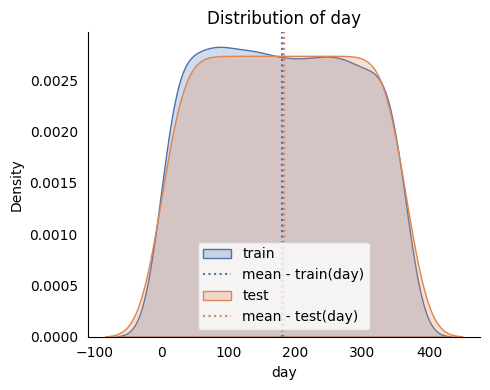

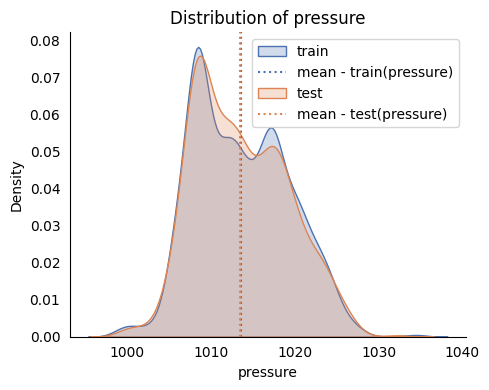

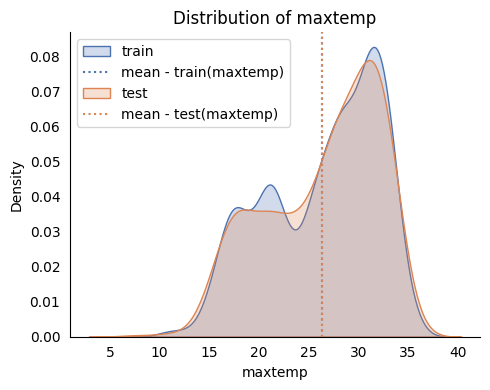

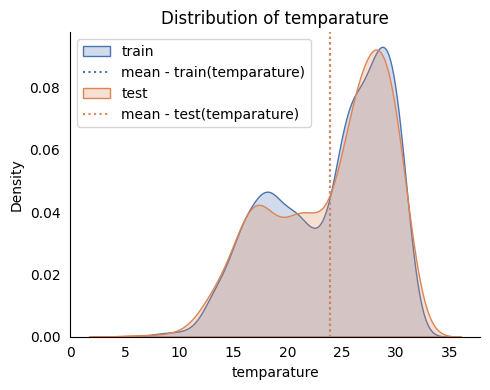

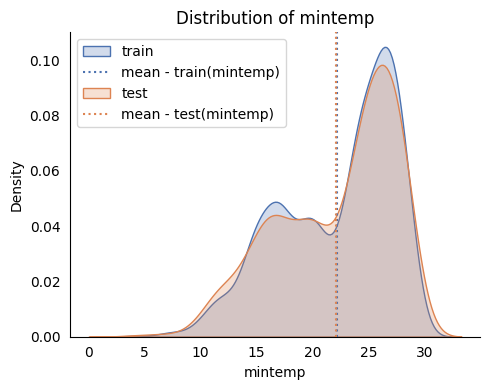

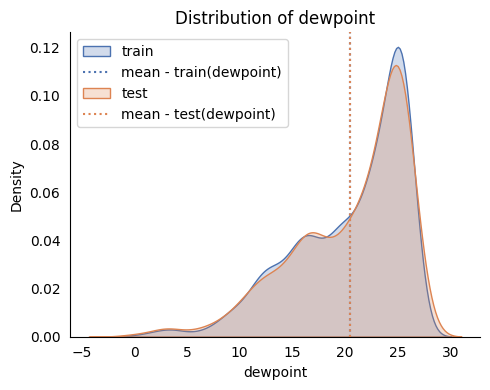

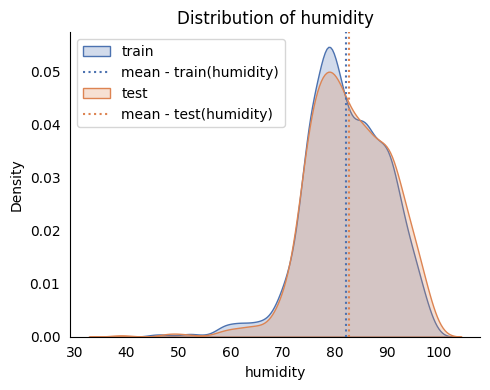

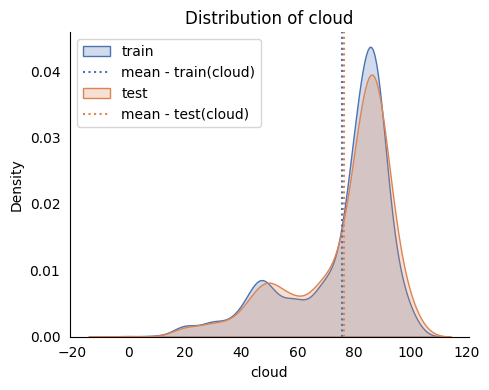

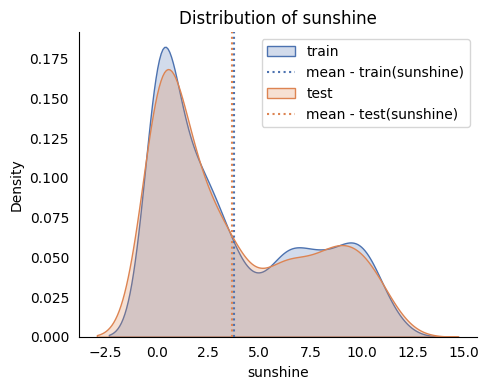

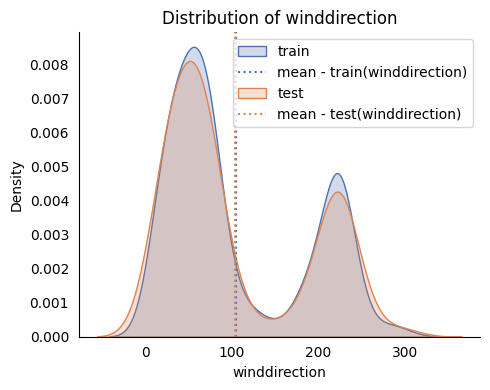

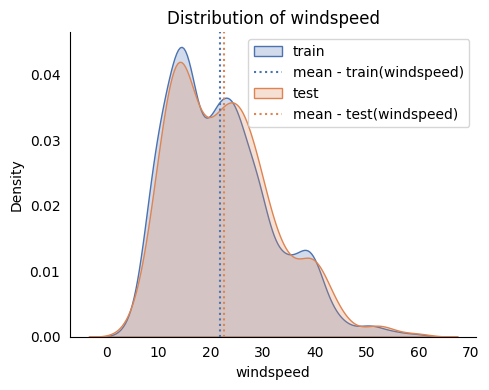

In [41]:
compare_data_through_univariate_plot(train, test, column_names=numeric_cols, titles=['train', 'test'], plot_type='kde+means', single_plot=True, color_palette='deep')

In [42]:
model_params_rf = {
    "n_estimators" : 100,
    "max_depth" : 6,
    "random_state" : 42,
    "n_jobs" : -1
}

ad_validator_rf = AdversarialValidator(RandomForestClassifier, model_params=model_params_rf)

In [43]:
model_params_xgb = {
    "n_estimators": 100,
    "max_depth": 5,
    "learning_rate": 0.1,
    "use_label_encoder": False,
    "eval_metric": 'logloss',
    "random_state": 42
}
ad_validator_xgb = AdversarialValidator(XGBClassifier, model_params=model_params_xgb)

In [44]:
ad_validator_rf.fit(train.drop(['id', 'rainfall'], axis=1), test.drop(['id'], axis=1))
print(ad_validator_rf.get_results())

{'auc_score': np.float64(0.49459630394139686), 'feature_importances': windspeed        0.125777
dewpoint         0.103245
temparature      0.101006
maxtemp          0.099986
pressure         0.094462
humidity         0.091230
mintemp          0.084451
day              0.082298
sunshine         0.081240
cloud            0.075225
winddirection    0.061079
dtype: float64}


In [45]:
ad_validator_xgb.fit(train.drop(['id', 'rainfall'], axis=1), test.drop(['id'], axis=1))
print(ad_validator_xgb.get_results())

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:01:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'auc_score': np.float64(0.49427659973728655), 'feature_importances': mintemp          0.101049
maxtemp          0.099700
winddirection    0.096904
humidity         0.094353
windspeed        0.091341
cloud            0.090987
temparature      0.090292
sunshine         0.086583
dewpoint         0.085767
pressure         0.083288
day              0.079736
dtype: float32}


From here we conclude that our training and prediction data follows same distribution.
Lets check for some insites from the train data in order to decide which features are important and relations between these features

## Train and Test Split

In [46]:
X = train.drop(['id', 'rainfall'], axis=1)
y = train['rainfall']

In [47]:
X_train, X_test= train_test_split(train, test_size=0.2, random_state=20)
X_train.shape, X_test.shape

((1752, 13), (438, 13))

In [48]:
X_train['rainfall'].value_counts()

,count
rainfall,
1,1324
0,428


In [49]:
X_test['rainfall'].value_counts()

,count
rainfall,
1,326
0,112


In [50]:
_, numeric_columns, object_columns, categorical_columns = get_numeric_or_categorical_columns(X_train, target_column='rainfall', ignore_columns=['id'])
print(f"num columns: {numeric_columns}")
print(f"cat columns: {categorical_columns}")

num columns: ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
cat columns: []


## Advarsarial Validation over Train and Test data

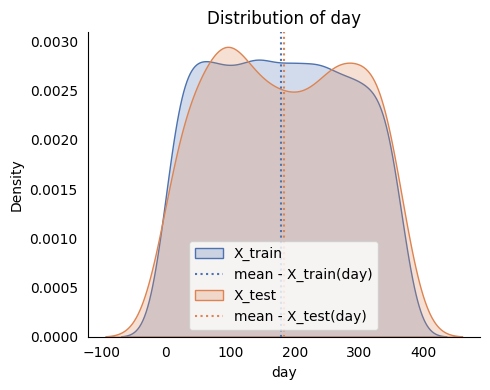

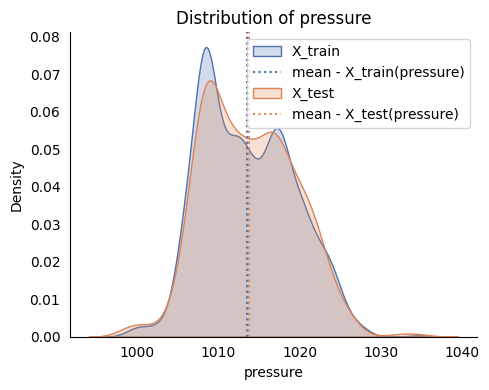

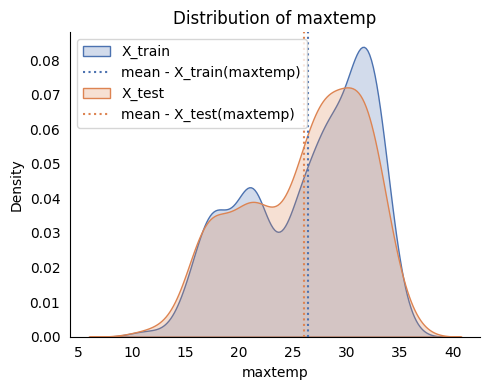

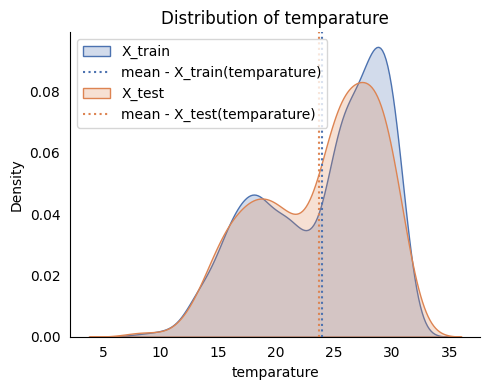

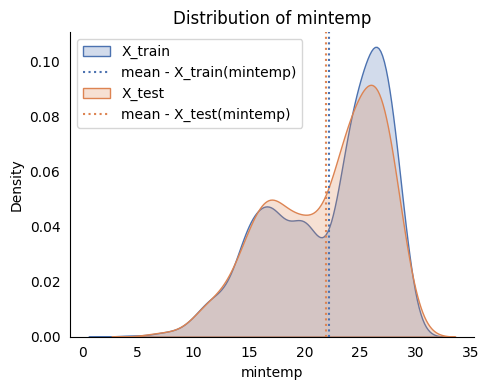

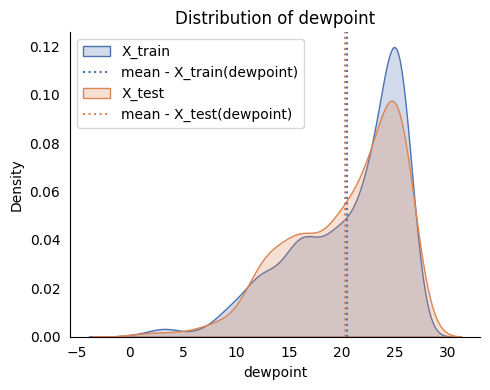

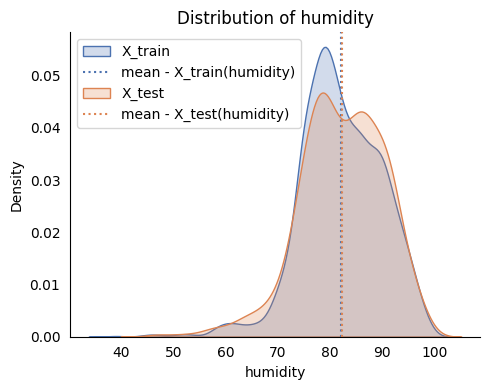

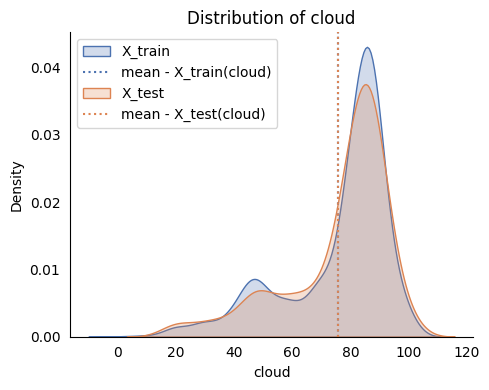

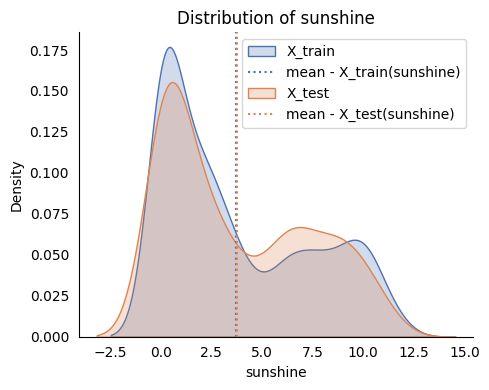

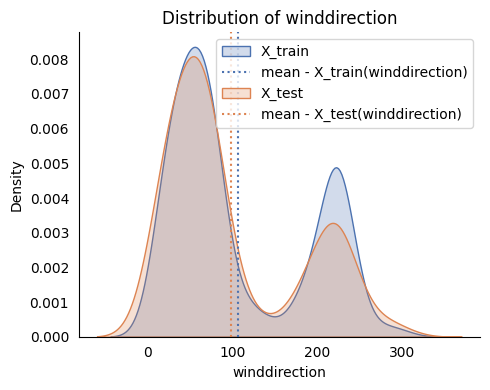

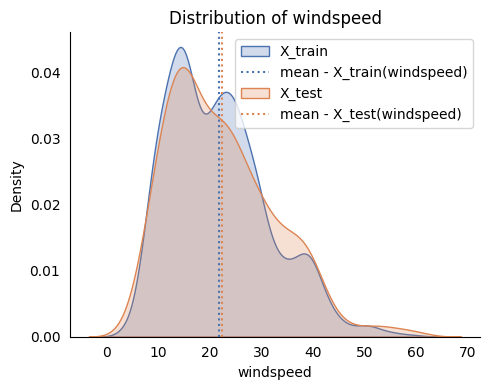

In [51]:
compare_data_through_univariate_plot(X_train, X_test, column_names=numeric_columns, titles=['X_train', 'X_test'], plot_type='kde+means', single_plot=True, color_palette='deep')

In [52]:
ad_validator_rf.fit(X_train, X_test)
ad_validator_rf.get_results()

{'auc_score': np.float64(0.5059646474907845),
 'feature_importances': id               0.140396
 windspeed        0.109632
 pressure         0.092180
 temparature      0.089218
 mintemp          0.080214
 humidity         0.080030
 dewpoint         0.073104
 winddirection    0.071172
 maxtemp          0.068800
 sunshine         0.068071
 day              0.063261
 cloud            0.060253
 rainfall         0.003671
 dtype: float64}

In [53]:
ad_validator_xgb.fit(X_train, X_test)
ad_validator_xgb.get_results()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:01:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'auc_score': np.float64(0.49611064348532785),
 'feature_importances': rainfall         0.106618
 id               0.092083
 sunshine         0.082496
 mintemp          0.080307
 pressure         0.077105
 cloud            0.076220
 day              0.075446
 windspeed        0.074289
 temparature      0.070490
 dewpoint         0.070076
 maxtemp          0.067689
 winddirection    0.066160
 humidity         0.061021
 dtype: float32}

We have divided training data into model traing and evaluation data. Lets explore it.

## Exploring Train Data set

In [54]:
X_train.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
id,1752.0,1095.300,628.581,0.0,558.750,1103.5,1636.250,2189.0
day,1752.0,179.030,104.777,1.0,88.000,178.0,268.000,365.0
pressure,1752.0,1013.563,5.658,999.0,1008.500,1013.0,1017.800,1034.6
maxtemp,1752.0,26.438,5.680,10.4,21.300,27.8,31.200,36.0
temparature,1752.0,24.005,5.253,7.4,19.300,25.5,28.425,31.4
mintemp,1752.0,22.223,5.093,4.0,17.800,24.0,26.500,29.8
dewpoint,1752.0,20.490,5.322,-0.3,16.800,22.3,25.000,26.7
humidity,1752.0,81.998,7.746,39.0,77.000,81.0,87.000,98.0
cloud,1752.0,75.708,18.049,2.0,69.000,83.0,88.000,100.0
sunshine,1752.0,3.740,3.646,0.0,0.400,2.4,6.900,12.1


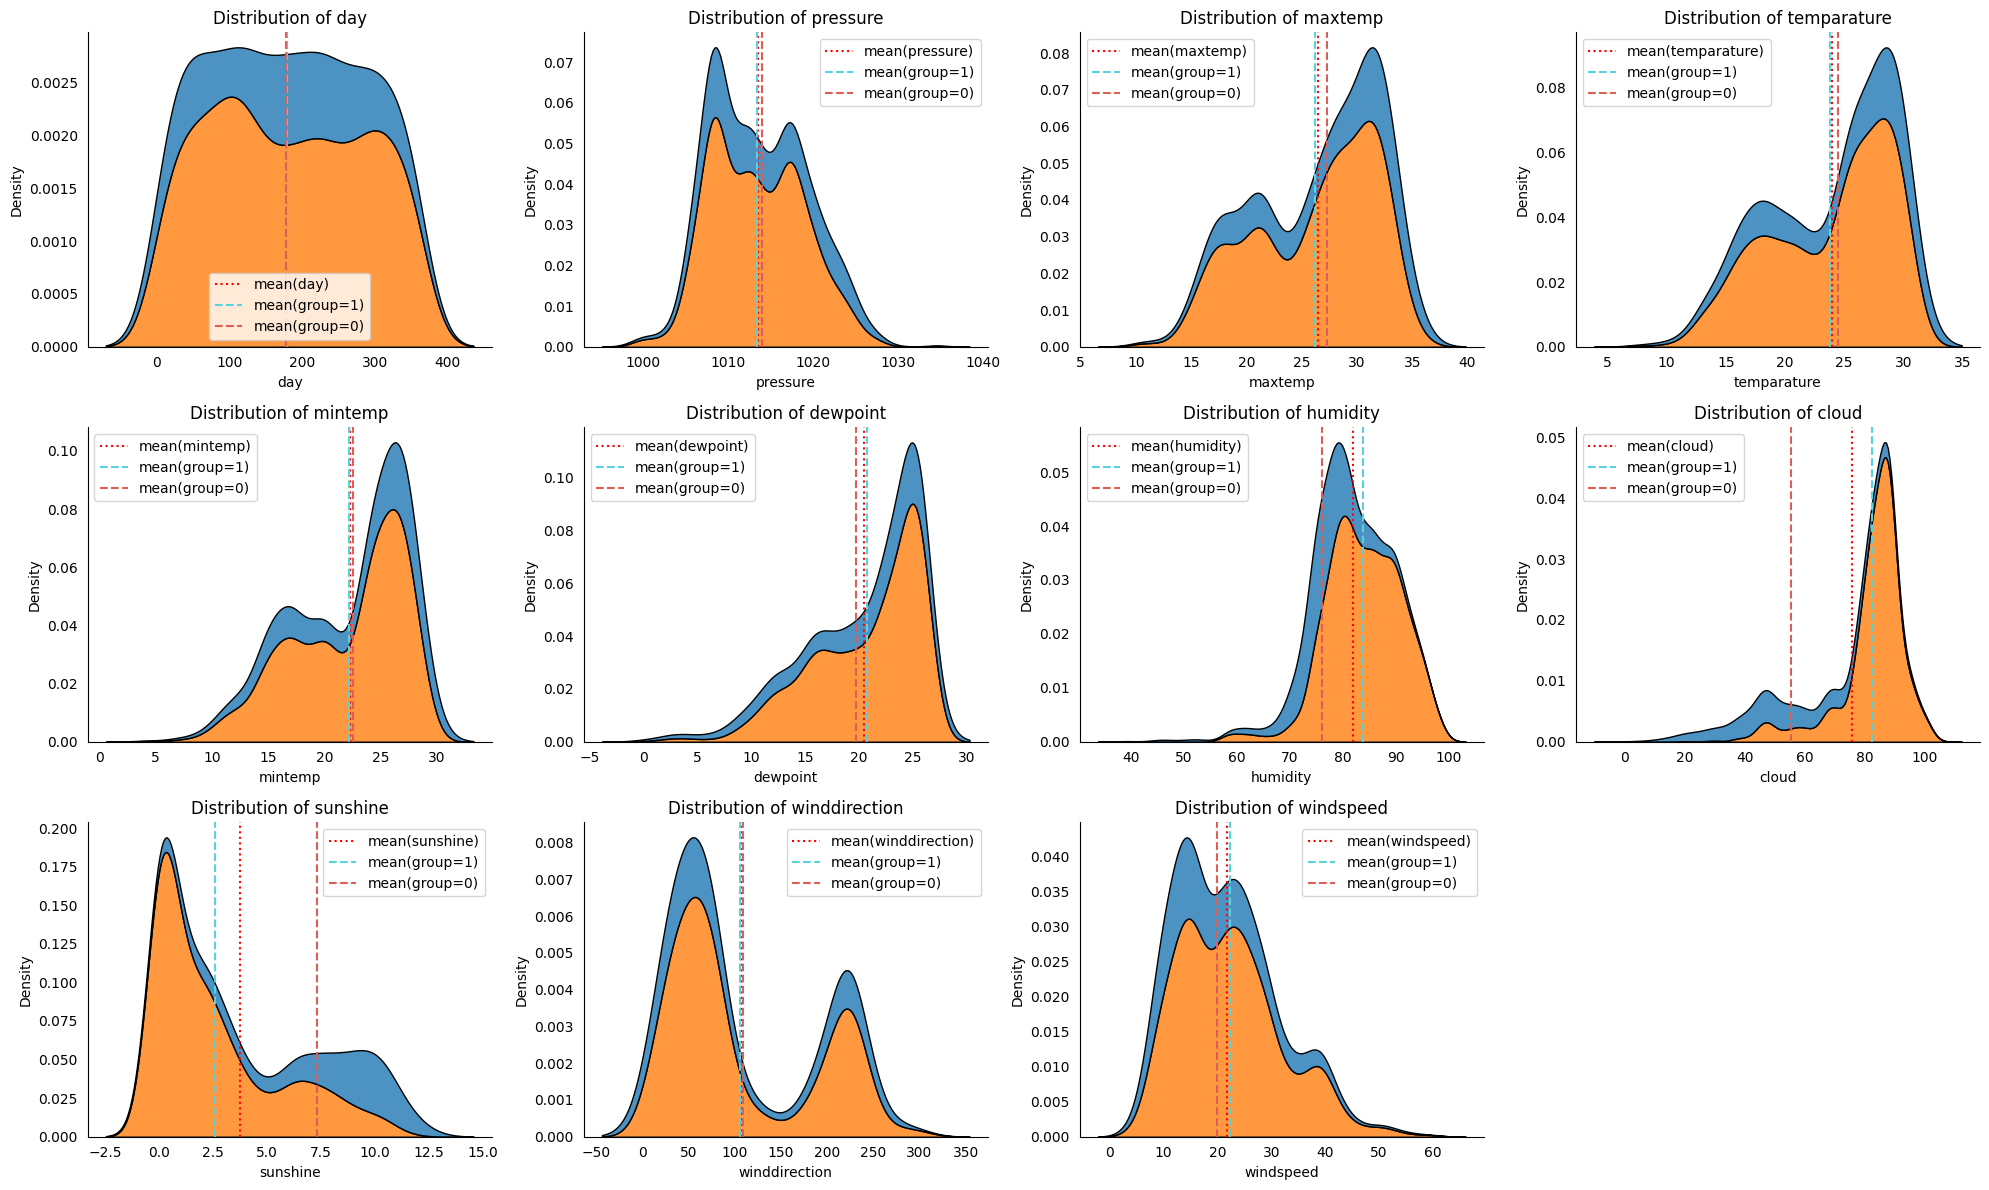

In [55]:
get_univariate_distribution_plot(X_train, column_names=numeric_columns, plot_type="kde+means", hue='rainfall', plot_kwargs={'alpha': 0.8})

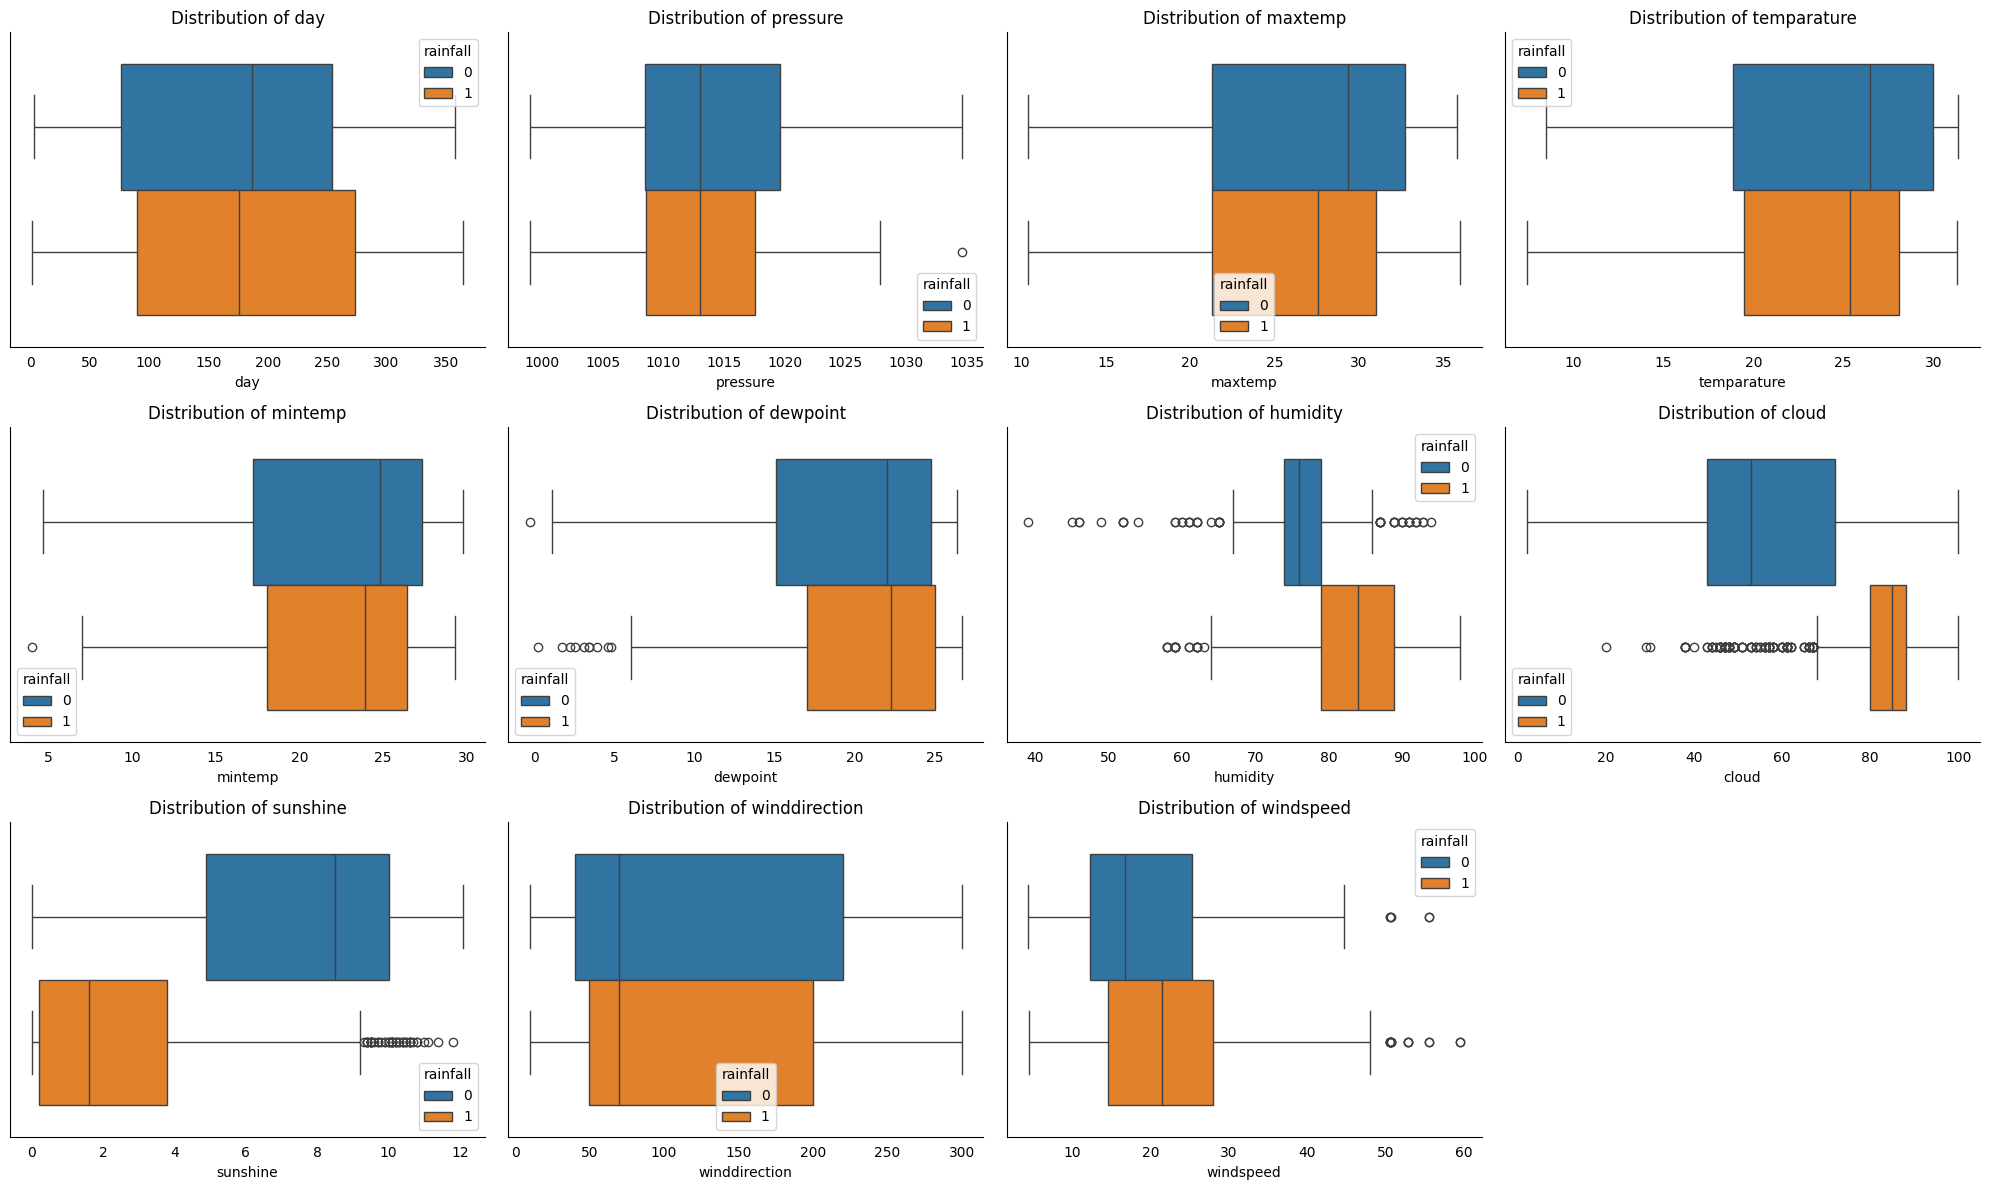

In [56]:
get_univariate_distribution_plot(X_train, column_names=numeric_cols, plot_type="box", hue='rainfall')

From here we come to know that sunshine is one of the best predictor of rainfall, behind that we have cloud and humidity
- Observations:
    - when sunshine level is below 4 hrs, there are high chances of rain.and when sunshile level is above 5 hrs there are high chances of no rain
    - when clouds are more than 80%, there are high chances of rain, but when clouds are below 70% there are very low chances of rain
    - when humidity at above 80% --> high chances of rain and below it, more than moderate chances of no rain.
    - humidity percentage ranges mostly from 60 to 90%.
- Actions
    - Here only 3 models we can predict as above
    - where just model check that cloud <=70 gets accuracy of 84% and confusion matrix as below
    -

<div style="float: right;">

|        |                       | Predicted: No Rain | Predicted: Rain |
|--------:|-----------------------:|--------------------:|-----------------:|
|        | **Actual: No Rain** | 77 | 35 |
|        | **Actual: Rain**    | 37| 239 |

</div>


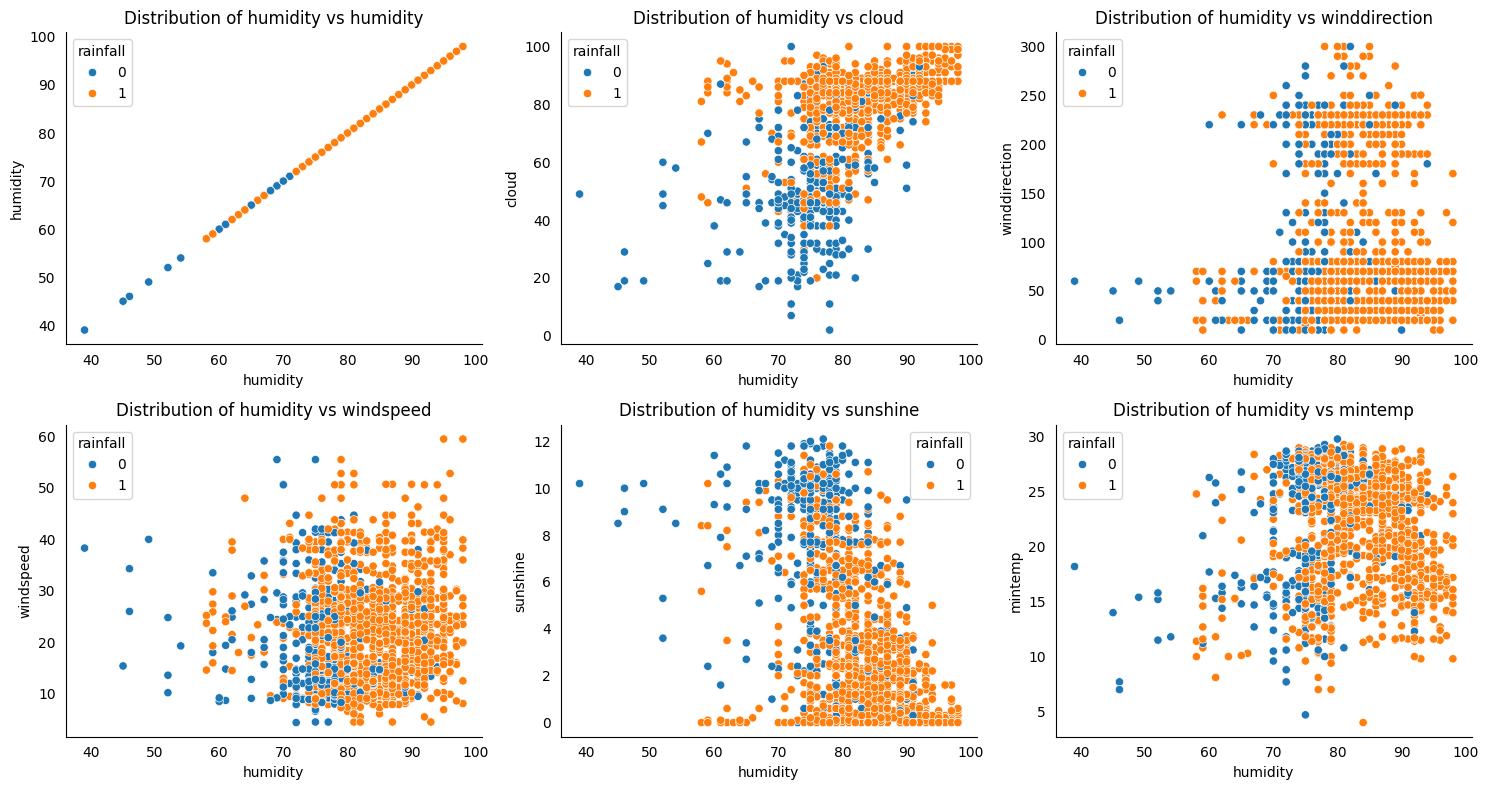

In [57]:
column_combinations = [
    ('humidity', 'humidity'), ('humidity', 'cloud'),
    ('humidity', 'winddirection'), ('humidity', 'windspeed'),
    ('humidity', 'sunshine'), ('humidity', 'mintemp')]
get_bivariate_distribution_plot(X_train, column_names=column_combinations, plotType="scatter", hue=y)

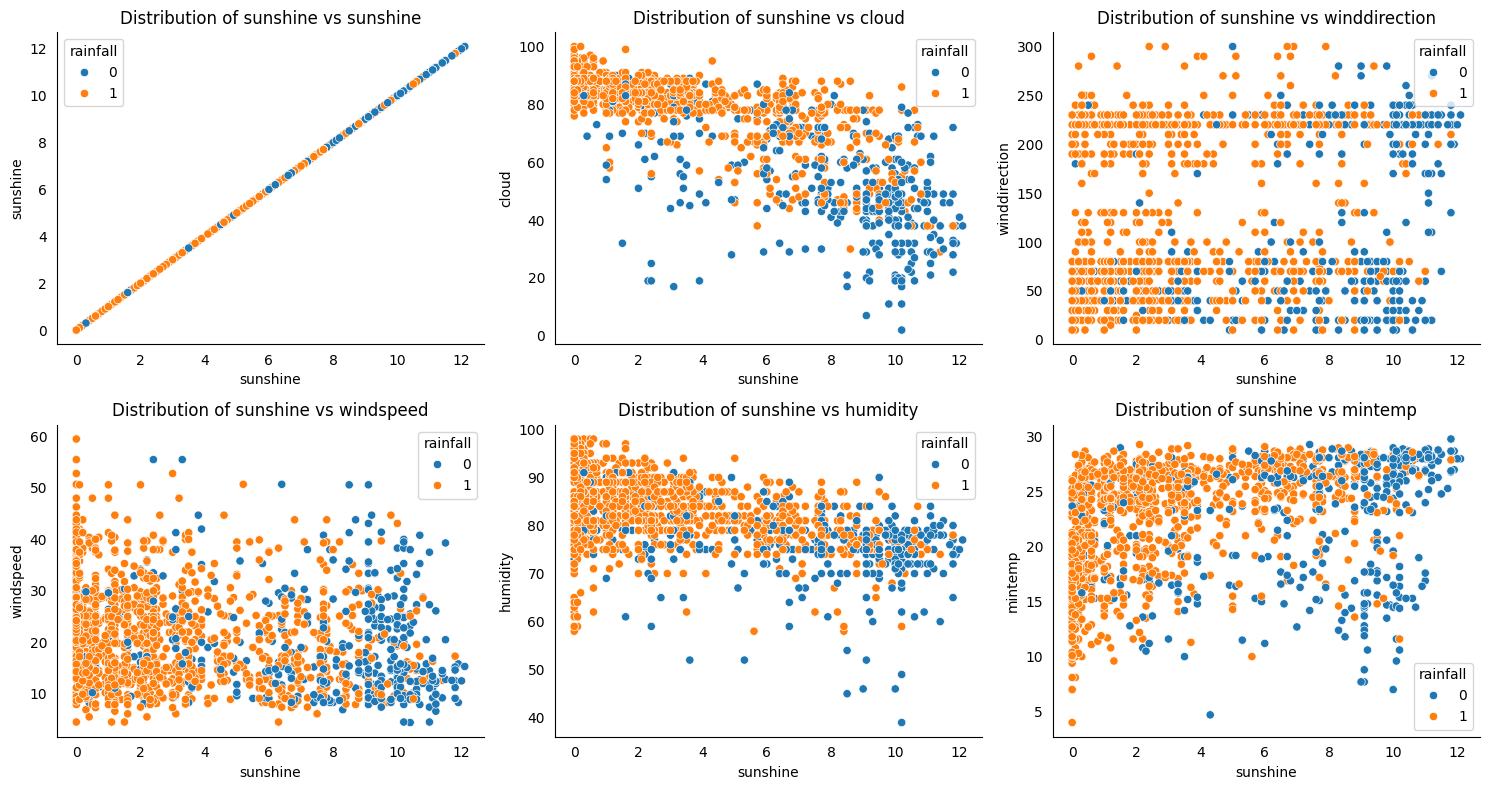

In [58]:
column_combinations = [
    ('sunshine', 'sunshine'), ('sunshine', 'cloud'),
    ('sunshine', 'winddirection'), ('sunshine', 'windspeed'),
    ('sunshine', 'humidity'), ('sunshine', 'mintemp')]
get_bivariate_distribution_plot(X_train, column_names=column_combinations, plotType="scatter", hue=y)

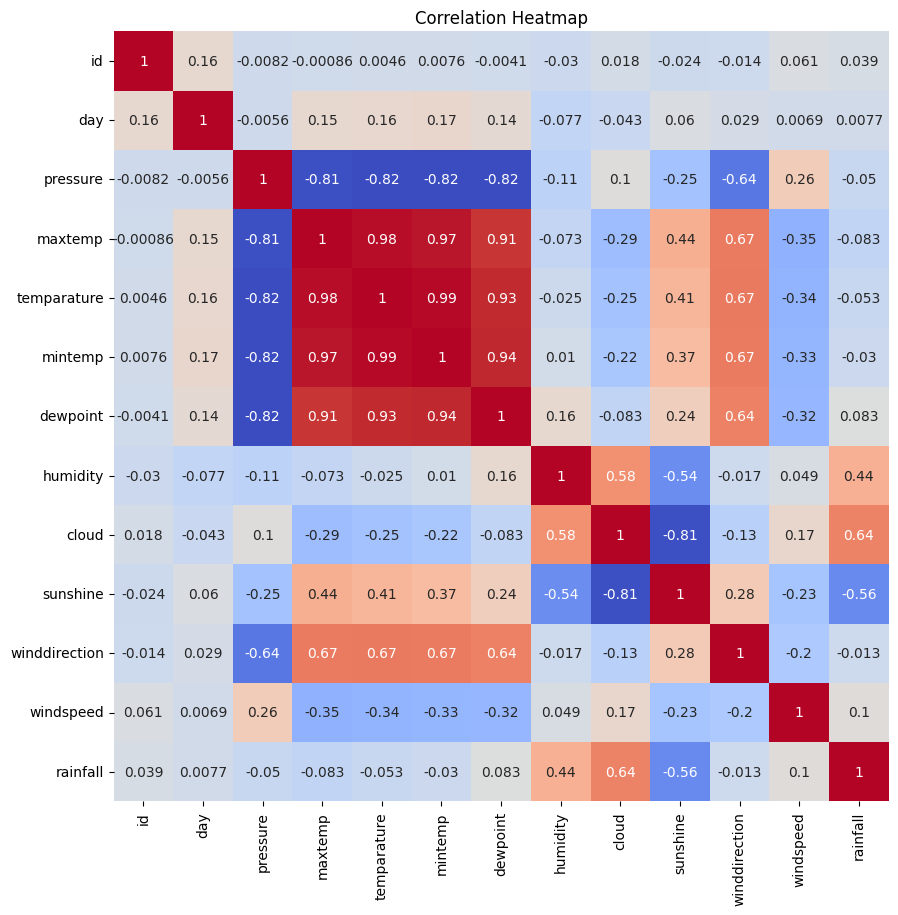

In [59]:
fig, axes = create_axes(1, figsize_per_plot=(10, 10))
ax = axes[0]  # Extract the single Axes object from the list

sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', ax=ax, cbar=False)
ax.set_title('Correlation Heatmap') # Use ax.set_title instead of ax.title
plt.show()

Here we come to know that there is too much correlated features present in training data. And with that we have very few data samples nearly 1800 to train, so we need to keep VC dimension of model as small as possible, or we can use average complex models with some regularization and validation applied

# Feature Selection

## Feature Extraction

In [60]:
print(numeric_cols)

['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


In [61]:
combiner = FeatureCombiner(operations=('add', 'multiply', 'divide'), return_original=False)
combined_train = combiner.fit_transform(X_train[numeric_cols])
combined_test = combiner.transform(X_test[numeric_cols])

In [62]:
created_features, created_numeric_features = get_numeric_or_categorical_columns(combined_train, ignore_columns=IGNORED_COLUMNS, get_features=['numeric'])
print(created_features)
print(created_numeric_features)
len(combined_train.columns.tolist())

['day_plus_pressure', 'day_times_pressure', 'day_div_pressure', 'day_plus_maxtemp', 'day_times_maxtemp', 'day_div_maxtemp', 'day_plus_temparature', 'day_times_temparature', 'day_div_temparature', 'day_plus_mintemp', 'day_times_mintemp', 'day_div_mintemp', 'day_plus_dewpoint', 'day_times_dewpoint', 'day_div_dewpoint', 'day_plus_humidity', 'day_times_humidity', 'day_div_humidity', 'day_plus_cloud', 'day_times_cloud', 'day_div_cloud', 'day_plus_sunshine', 'day_times_sunshine', 'day_div_sunshine', 'day_plus_winddirection', 'day_times_winddirection', 'day_div_winddirection', 'day_plus_windspeed', 'day_times_windspeed', 'day_div_windspeed', 'pressure_plus_maxtemp', 'pressure_times_maxtemp', 'pressure_div_maxtemp', 'pressure_plus_temparature', 'pressure_times_temparature', 'pressure_div_temparature', 'pressure_plus_mintemp', 'pressure_times_mintemp', 'pressure_div_mintemp', 'pressure_plus_dewpoint', 'pressure_times_dewpoint', 'pressure_div_dewpoint', 'pressure_plus_humidity', 'pressure_times_

165

In [63]:
simple_imputer = SimpleImputer(strategy='mean')
combined_train = simple_imputer.fit_transform(combined_train)
combined_train = pd.DataFrame(combined_train, columns=created_features, index=X_train.index)
combined_test = simple_imputer.transform(combined_test)
combined_test = pd.DataFrame(combined_test, columns=created_features, index=X_test.index)

In [64]:
corrReducer = CorrelationReducer(threshold=0.90)
combined_train = corrReducer.fit_transform(combined_train)
combined_test = corrReducer.transform(combined_test)

In [65]:
display(combined_train.shape)
display(combined_test.shape)

(1752, 39)

(438, 39)

In [66]:
print(combined_train.columns.tolist())
print(combined_test.columns.tolist())

['day_plus_pressure', 'day_div_dewpoint', 'day_div_cloud', 'day_times_sunshine', 'day_div_sunshine', 'day_plus_winddirection', 'day_times_winddirection', 'day_div_winddirection', 'day_times_windspeed', 'day_div_windspeed', 'pressure_plus_maxtemp', 'pressure_times_maxtemp', 'pressure_plus_dewpoint', 'pressure_plus_humidity', 'pressure_times_humidity', 'pressure_plus_cloud', 'pressure_div_cloud', 'pressure_plus_sunshine', 'pressure_times_sunshine', 'pressure_div_sunshine', 'pressure_plus_winddirection', 'pressure_div_winddirection', 'pressure_plus_windspeed', 'pressure_div_windspeed', 'maxtemp_div_temparature', 'maxtemp_div_mintemp', 'maxtemp_plus_humidity', 'maxtemp_times_cloud', 'maxtemp_plus_windspeed', 'temparature_div_mintemp', 'humidity_plus_sunshine', 'humidity_plus_windspeed', 'cloud_div_windspeed', 'sunshine_times_winddirection', 'sunshine_div_winddirection', 'sunshine_times_windspeed', 'sunshine_div_windspeed', 'winddirection_times_windspeed', 'winddirection_div_windspeed']
['d

In [67]:
display(combined_train.shape)
display(combined_test.shape)

display(combined_train.head())
display(combined_test.head())

(1752, 39)

(438, 39)

,day_plus_pressure,day_div_dewpoint,day_div_cloud,day_times_sunshine,day_div_sunshine,day_plus_winddirection,day_times_winddirection,day_div_winddirection,day_times_windspeed,day_div_windspeed,...,temparature_div_mintemp,humidity_plus_sunshine,humidity_plus_windspeed,cloud_div_windspeed,sunshine_times_winddirection,sunshine_div_winddirection,sunshine_times_windspeed,sunshine_div_windspeed,winddirection_times_windspeed,winddirection_div_windspeed
1627,1175.7,6.801619,2.507463,1327.2,21.265823,388.0,36960.0,0.763636,2150.4,13.125000,...,1.120155,91.9,96.8,5.234375,1738.0,0.035909,101.12,0.617188,2816.0,17.187500
854,1132.6,5.364807,1.893939,962.5,16.233766,200.0,9375.0,1.666667,1062.5,14.705882,...,1.133621,96.7,97.5,7.764706,577.5,0.102667,65.45,0.905882,637.5,8.823529
734,1029.4,0.581395,0.056818,0.0,184.362943,25.0,100.0,0.250000,196.5,0.127226,...,1.096154,77.0,116.3,2.239186,0.0,0.000000,0.00,0.000000,786.0,0.508906
146,1152.6,5.880000,3.868421,1749.3,12.352941,347.0,29400.0,0.735000,1220.1,17.710843,...,1.074074,85.9,82.3,4.578313,2380.0,0.059500,98.77,1.433735,1660.0,24.096386
1189,1106.5,4.112554,1.079545,171.0,52.777778,135.0,3800.0,2.375000,2147.0,4.203540,...,1.045082,91.8,112.6,3.893805,72.0,0.045000,40.68,0.079646,904.0,1.769912


,day_plus_pressure,day_div_dewpoint,day_div_cloud,day_times_sunshine,day_div_sunshine,day_plus_winddirection,day_times_winddirection,day_div_winddirection,day_times_windspeed,day_div_windspeed,...,temparature_div_mintemp,humidity_plus_sunshine,humidity_plus_windspeed,cloud_div_windspeed,sunshine_times_winddirection,sunshine_div_winddirection,sunshine_times_windspeed,sunshine_div_windspeed,winddirection_times_windspeed,winddirection_div_windspeed
1971,1156.1,6.391304,1.771084,205.8,105.000000,377.0,33810.0,0.639130,867.3,24.915254,...,1.027344,81.4,85.9,14.067797,322.0,0.006087,8.26,0.237288,1357.0,38.983051
316,1335.6,14.813084,3.522222,63.4,1585.000000,357.0,12680.0,7.925000,6086.4,16.510417,...,1.122172,92.2,111.2,4.687500,8.0,0.005000,3.84,0.010417,768.0,2.083333
1128,1053.5,2.048193,0.723404,231.2,5.000000,104.0,2380.0,0.485714,309.4,3.736264,...,1.180791,85.8,88.1,5.164835,476.0,0.097143,61.88,0.747253,637.0,7.692308
1646,1194.9,7.540323,6.448276,1327.7,26.338028,407.0,41140.0,0.850000,1552.1,22.530120,...,1.064394,85.1,86.3,3.493976,1562.0,0.032273,58.93,0.855422,1826.0,26.506024
1631,1178.8,6.515152,5.375000,1823.2,16.226415,322.0,25800.0,1.146667,2150.0,13.760000,...,1.117857,85.6,87.5,2.560000,1590.0,0.070667,132.50,0.848000,1875.0,12.000000


## Selection

In [68]:
J_train = pd.concat([X_train[numeric_cols], combined_train], axis=1)
l_train = X_train['rainfall']

J_test = pd.concat([X_test[numeric_cols], combined_test], axis=1)
l_test = X_test['rainfall']

display(J_train.shape)
display(l_train.shape)
display(J_test.shape)
display(l_test.shape)

(1752, 50)

(1752,)

(438, 50)

(438,)

In [69]:
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 1


In [70]:
models = {
    'logistic_regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=43))
    ]),
    'linear_svc': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LinearSVC(
              max_iter=1000,
              random_state=43,
            ))
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(
            n_estimators=20,
            min_samples_split=10,
            n_jobs=-1
            )
        )
    ])
}

k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [71]:
J_train.shape

(1752, 50)

In [72]:
feature_selection_results = {}

for name, model in models.items():
    display_markdown(f"## Running {name}...")
    selected_features, best_scores = forward_feature_selection(J_train, l_train, model, cv=k_fold, scoring='roc_auc' )
    feature_selection_results[name] = {'columns': selected_features, 'score': best_scores}

## Running logistic_regression...

Selected: pressure_div_cloud, Score: 0.8762
Selected: pressure_plus_sunshine, Score: 0.8838
Selected: pressure_plus_cloud, Score: 0.8895
Selected: humidity_plus_windspeed, Score: 0.8912
Selected: pressure_plus_dewpoint, Score: 0.8921
Selected: pressure_plus_maxtemp, Score: 0.8928
Selected: maxtemp_div_mintemp, Score: 0.8933
Selected: dewpoint, Score: 0.8933
Selected: day_div_dewpoint, Score: 0.8936
Selected: sunshine, Score: 0.8939
Selected: pressure_times_sunshine, Score: 0.8938
Selected: maxtemp, Score: 0.8938
Selected: pressure, Score: 0.8938
Selected: pressure_times_maxtemp, Score: 0.8938
Selected: winddirection_times_windspeed, Score: 0.8936
Selected: sunshine_div_winddirection, Score: 0.8937
Selected: sunshine_div_windspeed, Score: 0.8935
Selected: sunshine_times_winddirection, Score: 0.8935
Selected: maxtemp_times_cloud, Score: 0.8937
Selected: temparature_div_mintemp, Score: 0.8934
Selected: sunshine_times_windspeed, Score: 0.8932
Selected: maxtemp_div_temparature, Score: 0.893

## Running linear_svc...

Selected: pressure_div_cloud, Score: 0.8762
Selected: pressure_plus_sunshine, Score: 0.8866
Selected: pressure_plus_humidity, Score: 0.8900
Selected: windspeed, Score: 0.8908
Selected: maxtemp_div_temparature, Score: 0.8905
Selected: pressure_plus_dewpoint, Score: 0.8904
Selected: temparature_div_mintemp, Score: 0.8908
Selected: pressure_plus_maxtemp, Score: 0.8910
Selected: day_div_dewpoint, Score: 0.8916
Selected: maxtemp_div_mintemp, Score: 0.8917
Selected: day_plus_winddirection, Score: 0.8917
Selected: day_times_windspeed, Score: 0.8915
Selected: pressure_div_winddirection, Score: 0.8913
Selected: day_div_windspeed, Score: 0.8911
Selected: day_div_cloud, Score: 0.8908
Selected: pressure_div_windspeed, Score: 0.8906
Selected: pressure_div_sunshine, Score: 0.8901
Selected: winddirection_times_windspeed, Score: 0.8897
Selected: sunshine_times_winddirection, Score: 0.8897
Selected: cloud, Score: 0.8895
Selected: sunshine_div_windspeed, Score: 0.8894
Selected: day_div_sunshine, Score: 

## Running Random Forest...

Selected: cloud, Score: 0.8683
Selected: humidity, Score: 0.8736
Selected: day_div_windspeed, Score: 0.8794
Selected: day_times_windspeed, Score: 0.8818
Selected: day_div_dewpoint, Score: 0.8809
Selected: winddirection, Score: 0.8796
Selected: dewpoint, Score: 0.8809
Selected: pressure_plus_cloud, Score: 0.8857
Selected: pressure_plus_sunshine, Score: 0.8799
Selected: pressure_times_sunshine, Score: 0.8830
Selected: sunshine_div_winddirection, Score: 0.8835
Selected: sunshine_div_windspeed, Score: 0.8808
Selected: maxtemp_div_temparature, Score: 0.8816
Selected: mintemp, Score: 0.8788
Selected: pressure_plus_maxtemp, Score: 0.8794
Selected: pressure_times_maxtemp, Score: 0.8783
Selected: maxtemp_div_mintemp, Score: 0.8801
Selected: pressure_div_cloud, Score: 0.8807
Selected: day_plus_winddirection, Score: 0.8809
Selected: pressure_plus_winddirection, Score: 0.8814
Selected: pressure_div_sunshine, Score: 0.8794
Selected: maxtemp_times_cloud, Score: 0.8788
Selected: temparature_div_minte

In [73]:
for key, value in feature_selection_results.items():
    feature_selection_results[key] = pd.DataFrame(value)

In [74]:
for key, value in feature_selection_results.items():
    display_markdown(f"## {key}")
    display(value.head(np.argmax(value['score'])+1))

## logistic_regression

,columns,score
0,pressure_div_cloud,0.876172
1,pressure_plus_sunshine,0.883790
2,pressure_plus_cloud,0.889550
3,humidity_plus_windspeed,0.891179
4,pressure_plus_dewpoint,0.892086
5,pressure_plus_maxtemp,0.892756
6,maxtemp_div_mintemp,0.893275
7,dewpoint,0.893305
8,day_div_dewpoint,0.893646
9,sunshine,0.893860


## linear_svc

,columns,score
0,pressure_div_cloud,0.876172
1,pressure_plus_sunshine,0.886602
2,pressure_plus_humidity,0.890009
3,windspeed,0.890759
4,maxtemp_div_temparature,0.890508
5,pressure_plus_dewpoint,0.890369
6,temparature_div_mintemp,0.890813
7,pressure_plus_maxtemp,0.890973
8,day_div_dewpoint,0.891597
9,maxtemp_div_mintemp,0.891722


## Random Forest

,columns,score
0,cloud,0.868287
1,humidity,0.873598
2,day_div_windspeed,0.879448
3,day_times_windspeed,0.881843
4,day_div_dewpoint,0.880888
5,winddirection,0.879600
6,dewpoint,0.880920
7,pressure_plus_cloud,0.885720
8,pressure_plus_sunshine,0.879860
9,pressure_times_sunshine,0.882998


In [75]:
# Selected: cloud, Score: 0.8527
# Selected: day_times_sunshine, Score: 0.8602
# Selected: pressure_plus_winddirection, Score: 0.8693
# Selected: dewpoint, Score: 0.8699
# Selected: sunshine_div_windspeed, Score: 0.8716
# Selected: winddirection, Score: 0.8710
# Selected: pressure_plus_cloud, Score: 0.8687
# Selected: day_times_winddirection, Score: 0.8710
# Selected: pressure_plus_dewpoint, Score: 0.8739
# Selected: humidity_plus_windspeed, Score: 0.8705
# Selected: maxtemp_times_cloud, Score: 0.8710
# Selected: day, Score: 0.8727
# Selected: winddirection_times_windspeed, Score: 0.8716
# Selected: maxtemp, Score: 0.8733
# Selected: day_plus_winddirection, Score: 0.8727
# Selected: pressure_plus_maxtemp, Score: 0.8722
# Selected: day_div_winddirection, Score: 0.8733
# Selected: pressure_div_windspeed, Score: 0.8745
# Selected: sunshine_times_windspeed, Score: 0.8739
# Selected: sunshine_times_winddirection, Score: 0.8750
# Selected: pressure_times_maxtemp, Score: 0.8733
# Selected: pressure_div_cloud, Score: 0.8727
# Selected: pressure_div_sunshine, Score: 0.8727
# Selected: day_div_dewpoint, Score: 0.8733
# Selected: maxtemp_plus_windspeed, Score: 0.8733
# Selected: sunshine, Score: 0.8722
# Selected: day_times_windspeed, Score: 0.8716
# Selected: windspeed, Score: 0.8710
# Selected: day_div_windspeed, Score: 0.8710
# Selected: sunshine_div_winddirection, Score: 0.8750

## Model selection

In [76]:
models['svc'] =  Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC())
    ])
models['xg_boost'] = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier())
])

In [77]:
param_grid = {
    'logistic_regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],  # Removed 'lbfgs' which doesn't support l1
        'classifier__max_iter': [5000],  # Increased for convergence
        'classifier__l1_ratio': [None],  # Explicitly handle elasticnet mix
        'classifier__class_weight': ["balanced", "balanced_subsample", {0:3, 1:1}, {0:5, 1:2}]
    },
    'linear_svc': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l2'],  # Only l2 supported with hinge loss
        'classifier__loss': ['hinge', 'squared_hinge'],
        'classifier__dual': [True],  # Dual must be True for l2
        'classifier__max_iter': [10000],  # Increased iterations
        'classifier__class_weight': ["balanced", "balanced_subsample", {0:3, 1:1}, {0:5, 1:2}]

    },
    'svc': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__degree': [2, 3, 4],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__class_weight': ["balanced", "balanced_subsample", {0:3, 1:1}, {0:5, 1:2}]

    },
    'xg_boost': {
        'classifier__n_estimators': [50, 100, 200, 300, 400, 500],
        'classifier__max_depth': [3, 4, 5, 6, 7, 8],
        'classifier__learning_rate': [0.001, 0.01, 0.1, 1, 10]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [5, 7, None],
        'classifier__min_samples_split': [2, 4, 6],
        'classifier__class_weight': ["balanced", "balanced_subsample", {0:3, 1:1}, {0:5, 1:2}]
    }
}

In [78]:
def get_best_features(model_name):
    ensemble = ['Random Forest', 'xg_boost']
    svm = ['svc', 'linear_svc']
    linear = ['logistic_regression']
    if model_name in ensemble:
        column_limit = np.argmax(feature_selection_results['Random Forest']['score'])+1
        best_features = feature_selection_results['Random Forest'].loc[:column_limit, 'columns'].to_list()
    elif model_name in svm:
        column_limit = np.argmax(feature_selection_results['linear_svc']['score'])+1
        best_features = feature_selection_results['linear_svc'].loc[:column_limit, 'columns'].to_list()
    else:
        column_limit = np.argmax(feature_selection_results['logistic_regression']['score'])+1
        best_features = feature_selection_results['logistic_regression'].loc[:column_limit, 'columns'].to_list()
    return best_features

In [79]:
cv_results = {}
for i, model_name in enumerate(models.keys()):
    display_markdown(f"## Running {model_name}...")
    best_features = get_best_features(model_name)
    x_train = J_train[best_features]
    y_train = l_train

    x_test = J_test[best_features]
    y_test = l_test

    model = models[model_name]
    param = param_grid[model_name]

    clf = RandomizedSearchCV(
        model, param, random_state=0, cv=k_fold, n_jobs=-1, verbose=1,
        scoring='roc_auc', n_iter=20
    )
    clf.fit(x_train, y_train)

    result = {
        "cv_results_": clf.cv_results_,
        "best_params_": clf.best_params_,
        "best_score_": clf.best_score_,
        "best_estimator_": clf.best_estimator_,
    }

    cv_results[model_name] = result


## Running logistic_regression...

Fitting 10 folds for each of 20 candidates, totalling 200 fits


## Running linear_svc...

Fitting 10 folds for each of 20 candidates, totalling 200 fits


## Running Random Forest...

Fitting 10 folds for each of 20 candidates, totalling 200 fits


## Running svc...

Fitting 10 folds for each of 20 candidates, totalling 200 fits


## Running xg_boost...

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [80]:
for model_name, result in cv_results.items():
    print(f"Model: {model_name}")
    print(f"Best Parameters: {result['best_params_']}")
    print(f"Best Score: {result['best_score_']}")
    print(f"Best Estimator: {result['best_estimator_']}")
    print("\n")

Model: logistic_regression
Best Parameters: {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__max_iter': 5000, 'classifier__l1_ratio': None, 'classifier__class_weight': 'balanced', 'classifier__C': 0.1}
Best Score: 0.8923314023506366
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=5000, penalty='l1',
                                    random_state=43, solver='saga'))])


Model: linear_svc
Best Parameters: {'classifier__penalty': 'l2', 'classifier__max_iter': 10000, 'classifier__loss': 'hinge', 'classifier__dual': True, 'classifier__class_weight': {0: 5, 1: 2}, 'classifier__C': 1}
Best Score: 0.8921606152197166
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LinearSVC(C=1, class_weight={0: 5, 1: 2}, dual=True,
                           loss='hing

# Training

In [81]:

best_model = None
best_score = -np.inf  # Initialize with negative infinity

for model_name, result in cv_results.items():
    if result['best_score_'] > best_score:
        best_score = result['best_score_']
        best_model = model_name

# Get the result for the best model
best_result = cv_results[best_model]

print(f"The best model is: {best_model}")
print(f"Best parameters: {best_result['best_params_']}")
print(f"Best score: {best_result['best_score_']}")
print(f"Best estimator: {best_result['best_estimator_']}")


The best model is: logistic_regression
Best parameters: {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__max_iter': 5000, 'classifier__l1_ratio': None, 'classifier__class_weight': 'balanced', 'classifier__C': 0.1}
Best score: 0.8923314023506366
Best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=5000, penalty='l1',
                                    random_state=43, solver='saga'))])


In [82]:
model = best_result['best_estimator_']
best_features = get_best_features(best_model)

In [83]:
x_train = J_train[best_features]
y_train = l_train

x_test = J_test[best_features]
y_test = l_test

In [84]:
model.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=5000, penalty='l1',
                                    random_state=43, solver='saga'))])

In [85]:
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)

In [86]:
# @title Default title text
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       112
           1       0.91      0.89      0.90       326

    accuracy                           0.85       438
   macro avg       0.81      0.82      0.81       438
weighted avg       0.86      0.85      0.86       438



ROC AUC Score: 0.9006901840490799


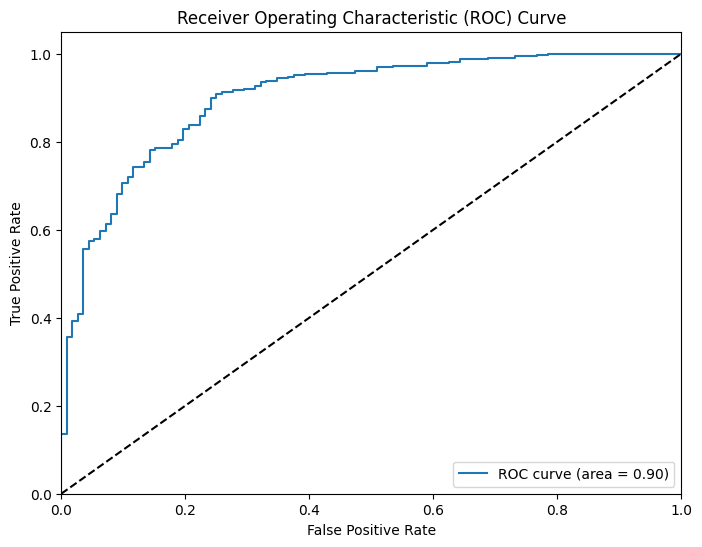

In [87]:
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])  # Assuming binary classification, take probability of positive class
print(f"ROC AUC Score: {roc_auc}")


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [88]:
# save the best model
import joblib
joblib.dump(model, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

# Another good model test

In [89]:
linear_svc = cv_results['linear_svc']['best_estimator_']
params = cv_results['linear_svc']['best_params_']
best_features = get_best_features('linear_svc')

In [90]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_svc = CalibratedClassifierCV(linear_svc, method='sigmoid', cv=5)

In [91]:
x_train = J_train[best_features]
y_train = l_train

x_test = J_test[best_features]
y_test = l_test

In [92]:
calibrated_svc.fit(x_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('classifier',
                                                  LinearSVC(C=1,
                                                            class_weight={0: 5,
                                                                          1: 2},
                                                            dual=True,
                                                            loss='hinge',
                                                            max_iter=10000,
                                                            random_state=43))]))

In [93]:
y_pred = calibrated_svc.predict(x_test)
y_pred_proba = calibrated_svc.predict_proba(x_test)

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.54      0.65       112
           1       0.86      0.96      0.91       326

    accuracy                           0.85       438
   macro avg       0.84      0.75      0.78       438
weighted avg       0.85      0.85      0.84       438



ROC AUC Score: 0.9020595968448729


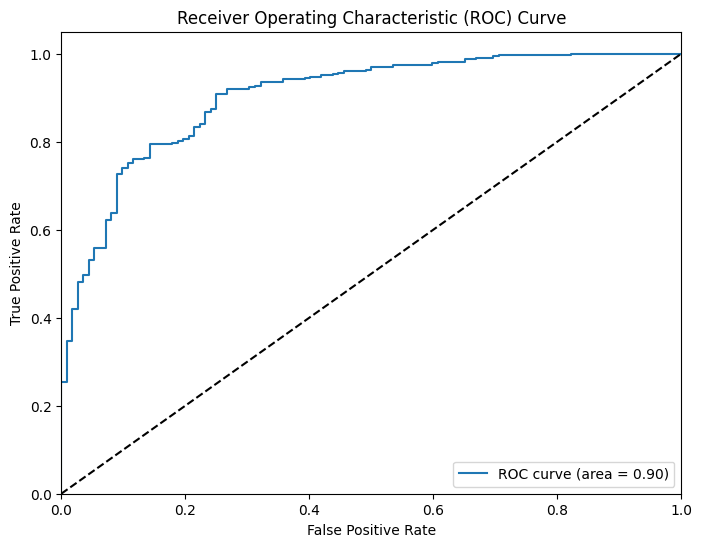

In [95]:
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])  # Assuming binary classification, take probability of positive class
print(f"ROC AUC Score: {roc_auc}")


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [96]:
# save model
import joblib
joblib.dump(calibrated_svc, 'calibrated_svc.pkl')

['calibrated_svc.pkl']

# Prediction

In [97]:
test.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [98]:
combined_pred = combiner.transform(test[numeric_cols])
combined_pred = simple_imputer.transform(combined_pred)
combined_pred = pd.DataFrame(combined_pred, columns=created_features, index=test.index)
combined_pred = corrReducer.transform(combined_pred)

In [99]:
J_pred = pd.concat([test[numeric_cols], combined_pred], axis=1)

display(J_pred.shape)
display(J_pred.head())

(730, 50)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,temparature_div_mintemp,humidity_plus_sunshine,humidity_plus_windspeed,cloud_div_windspeed,sunshine_times_winddirection,sunshine_div_winddirection,sunshine_times_windspeed,sunshine_div_windspeed,winddirection_times_windspeed,winddirection_div_windspeed
0,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,...,1.244094,96.0,120.3,4.074074,0.0,0.000,0.00,0.000000,1215.0,2.057613
1,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,...,1.044304,97.0,132.3,2.804533,0.0,0.000,0.00,0.000000,1765.0,1.416431
2,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,...,1.106383,86.0,102.9,5.680473,0.0,0.000,0.00,0.000000,676.0,2.366864
3,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,...,1.138158,82.1,125.6,0.889328,142.0,0.355,359.26,0.140316,1012.0,0.395257
4,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,...,2.156250,77.2,87.4,2.525773,184.0,0.460,178.48,0.474227,388.0,1.030928


In [100]:
best_features_logistics = get_best_features('logistic_regression')
best_features_linear_svc = get_best_features('linear_svc')

In [101]:
x_pred_logistics = J_pred[best_features_logistics]
x_pred_linear_svc = J_pred[best_features_linear_svc]

In [102]:
# load both models from saved files
logistic_regression_model = joblib.load('logistic_regression_model.pkl')
linear_svc_model = joblib.load('calibrated_svc.pkl')

In [103]:
y_pred_logistics = logistic_regression_model.predict(x_pred_logistics)
y_pred_linear_svc = linear_svc_model.predict(x_pred_linear_svc)

In [104]:
y_pred_logistics = pd.Series(y_pred_logistics, name='rainfall')
y_pred_linear_svc = pd.Series(y_pred_linear_svc, name='rainfall')

In [105]:
output_df1 = pd.concat([test['id'], y_pred_logistics], axis=1)
output_df2 = pd.concat([test['id'], y_pred_linear_svc], axis=1)

In [106]:
# save files
output_df1.to_csv('submission_logistics.csv', index=False)
output_df2.to_csv('submission_svc.csv', index=False)